# STEP 1

In [1]:
import numpy as np

clean_data = np.loadtxt('wifi_db/clean_dataset.txt')
noisy_data = np.loadtxt('wifi_db/noisy_dataset.txt')

# STEP 2

In [2]:
def entropy(dataset):
    _, counts = np.unique(dataset[:,-1], return_counts=True)
    ps = counts / dataset.shape[0]

    return -np.sum(ps * np.log2(ps))

entropy(clean_data)

np.float64(2.0)

In [3]:
def remainder(s_left, s_right):
    n_left = s_left.shape[0]
    n_right = s_right.shape[0]

    return (n_left * entropy(s_left) + n_right * entropy(s_right)) / (n_left + n_right)

remainder(clean_data[:1000], clean_data[1000:])

np.float64(1.0)

In [4]:
def info_gain(all, left, right):
    return entropy(all) - remainder(left, right)

info_gain(clean_data, clean_data[:500], clean_data[500:])

np.float64(0.8112781244591329)

In [5]:
def find_split(dataset):
    num_features = dataset[:,:-1].shape[1]

    max_feature = -1
    max_gain = -1
    max_left = -1
    max_right = -1
    for feature in range(num_features):
        sorted_data = dataset[dataset[:, feature].argsort()]
        features = sorted_data[:, :-1]
        labels = sorted_data[:, -1]

        for point in range(len(features) - 1):
            if labels[point] == labels[point + 1]:
                continue

            left = sorted_data[:point + 1, :]
            right = sorted_data[point + 1:, :]
            curr_gain = info_gain(sorted_data, left, right)
            if curr_gain > max_gain:
                max_gain = curr_gain
                max_feature = feature
                max_left = left
                max_right = right


    return {'feature': max_feature, 'threshold': max_left[-1, max_feature], 'left': max_left, 'right': max_right}

find_split(clean_data)

{'feature': 0,
 'threshold': np.float64(-55.0),
 'left': array([[-74., -62., -66., ..., -89., -87.,   1.],
        [-73., -62., -66., ..., -87., -89.,   1.],
        [-73., -61., -65., ..., -89., -90.,   1.],
        ...,
        [-55., -60., -51., ..., -85., -87.,   3.],
        [-55., -50., -51., ..., -82., -79.,   4.],
        [-55., -52., -46., ..., -88., -84.,   4.]]),
 'right': array([[-55., -53., -52., ..., -85., -88.,   3.],
        [-55., -51., -51., ..., -89., -78.,   3.],
        [-55., -66., -57., ..., -84., -84.,   3.],
        ...,
        [-10., -57., -57., ..., -82., -72.,   2.],
        [-10., -58., -54., ..., -72., -73.,   2.],
        [-10., -58., -62., ..., -76., -74.,   2.]])}

In [6]:
def decision_tree_learning(dataset, depth=1):
    y = dataset[:, -1]

    if len(np.unique(y)) == 1:
        return {'value': y[0]}, depth
            
    split = find_split(dataset)

    l_branch, l_depth = decision_tree_learning(split['left'], depth + 1)
    r_branch, r_depth = decision_tree_learning(split['right'], depth + 1)

    node = {'feature': split['feature'], 'value': split['threshold'], 'left': l_branch, 'right': r_branch}

    return node, max(l_depth, r_depth)

decision_tree_learning(clean_data)

({'feature': 0,
  'value': np.float64(-55.0),
  'left': {'feature': 4,
   'value': np.float64(-60.0),
   'left': {'feature': 2,
    'value': np.float64(-51.0),
    'left': {'feature': 2,
     'value': np.float64(-56.0),
     'left': {'value': np.float64(1.0)},
     'right': {'feature': 6,
      'value': np.float64(-87.0),
      'left': {'feature': 3,
       'value': np.float64(-62.0),
       'left': {'feature': 4,
        'value': np.float64(-63.0),
        'left': {'value': np.float64(1.0)},
        'right': {'value': np.float64(4.0)}},
       'right': {'feature': 0,
        'value': np.float64(-60.0),
        'left': {'value': np.float64(4.0)},
        'right': {'value': np.float64(3.0)}}},
      'right': {'value': np.float64(1.0)}}},
    'right': {'feature': 3,
     'value': np.float64(-59.0),
     'left': {'feature': 0,
      'value': np.float64(-58.0),
      'left': {'value': np.float64(1.0)},
      'right': {'value': np.float64(4.0)}},
     'right': {'feature': 2,
      'value': 

In [7]:
def layout(tree, depth):
    points = [] # [(x,y, attribute, value)]
    arrows = [] # [((x1,y1), (x2,y2))]

    def dfs(tree, x, y):
        if not tree:
            return
        
        if not 'left' in tree and not 'right' in tree:
            points.append((x, y, None, tree['value'] ))
            return
        
        points.append((x, y, tree['feature'], tree['value']))
        offset_x = 2 ** (depth - y - 2)
        
        left_x = x - offset_x
        right_x = x + offset_x

        # TODO: arrow stuff

        dfs(tree['left'], left_x, y + 1)
        dfs(tree['right'], right_x, y + 1)

    dfs(tree, 2**(depth - 1) - 1, 0)

    return points, arrows

# res = decision_tree_learning(clean_data)
layout(*decision_tree_learning(clean_data))

([(2047, 0, 0, np.float64(-55.0)),
  (1023, 1, 4, np.float64(-60.0)),
  (511, 2, 2, np.float64(-51.0)),
  (255, 3, 2, np.float64(-56.0)),
  (127, 4, None, np.float64(1.0)),
  (383, 4, 6, np.float64(-87.0)),
  (319, 5, 3, np.float64(-62.0)),
  (287, 6, 4, np.float64(-63.0)),
  (271, 7, None, np.float64(1.0)),
  (303, 7, None, np.float64(4.0)),
  (351, 6, 0, np.float64(-60.0)),
  (335, 7, None, np.float64(4.0)),
  (367, 7, None, np.float64(3.0)),
  (447, 5, None, np.float64(1.0)),
  (767, 3, 3, np.float64(-59.0)),
  (639, 4, 0, np.float64(-58.0)),
  (575, 5, None, np.float64(1.0)),
  (703, 5, None, np.float64(4.0)),
  (895, 4, 2, np.float64(-47.0)),
  (831, 5, None, np.float64(3.0)),
  (959, 5, None, np.float64(4.0)),
  (1535, 2, 4, np.float64(-57.0)),
  (1279, 3, 3, np.float64(-59.0)),
  (1151, 4, None, np.float64(4.0)),
  (1407, 4, None, np.float64(3.0)),
  (1791, 3, None, np.float64(4.0)),
  (3071, 1, 0, np.float64(-45.0)),
  (2559, 2, 4, np.float64(-71.0)),
  (2303, 3, 3, np.float64(

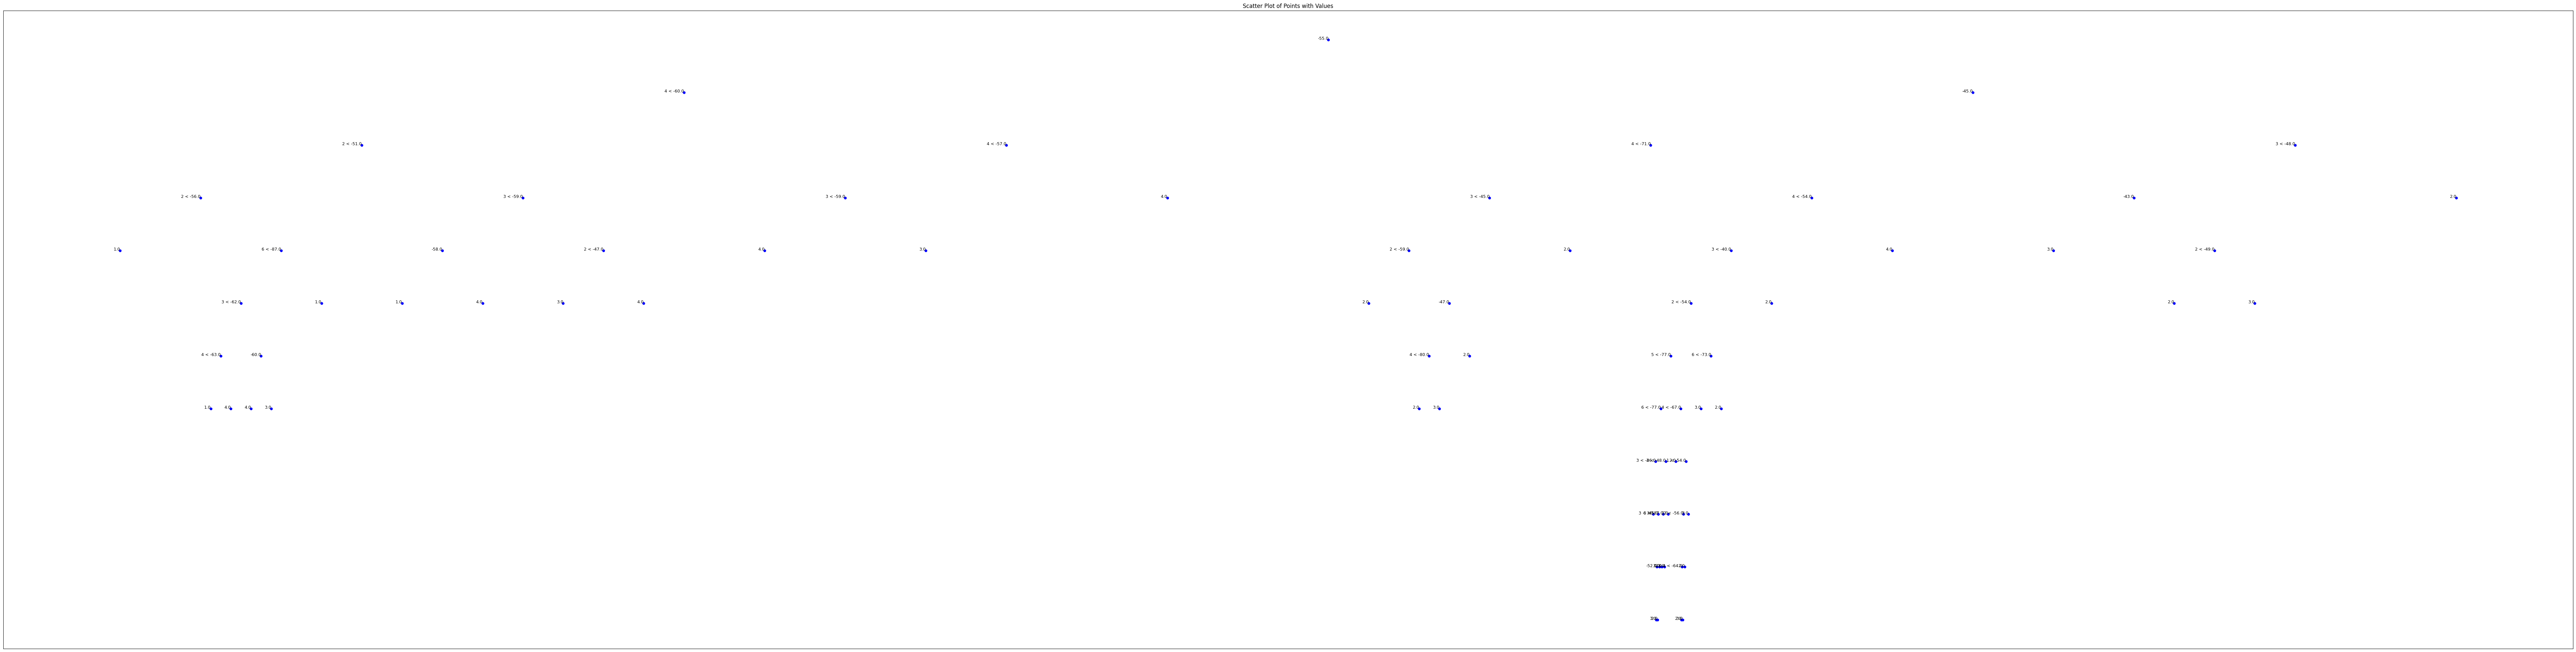

In [9]:
import matplotlib.pyplot as plt

def draw_tree(nodes, arrows):
    s = 24

    x_coords = [(2*s + 6) * point[0] for point in nodes]
    y_coords = [-point[1] for point in nodes]
    features = [point[2] for point in nodes]
    values = [point[3] for point in nodes]

    # Create a scatter plot
    plt.figure(figsize=(100, 25))
    plt.scatter(x_coords, y_coords, color='blue', s=s)

    # Annotate each point with its corresponding value
    for i, value in enumerate(values):
        if not features[i]:
            plt.text(x_coords[i], y_coords[i], f'{value}', fontsize=9, ha='right')
        else:
            plt.text(x_coords[i], y_coords[i], f'{features[i]} < {value}', fontsize=9, ha='right')

    # Hide x and y axes
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)

    # Adding title
    plt.title('Scatter Plot of Points with Values')

    # Display the plot
    plt.grid(True)
    plt.show()

draw_tree(*layout(*decision_tree_learning(clean_data)))